In [1]:
import qamuy.chemistry as qy
from qamuy.client import Client

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# You can fill in your e-mail address and password.
client = Client(email_address="ryzhou@live.unc.edu", password="rEKv3012")

In [2]:
input = qy.QamuyChemistryInput()
ps = input.target_periodic_system

In [3]:
# see also https://sunqm.github.io/pyscf/modules/pbc/gto.html
#BOHR = 0.529 # unit: angstrom
#unitcell_x = 4. * BOHR
#unitcell_yz = 1.
atoms = ["C","C","H", "H"]
coords = [[-0.58442 ,  -0.32662 , 0.0 ],[0.58442 ,  0.32662 ,  0.0  ],[ 0.58442  , 1.40362   ,0.0],[ -0.58442   ,-1.40362 , 0.0    
]]
lattice_vec = [[2.469000000, 0., 0.], [0.,10, 0.], [0., 0., 10]]
kpt_grid_shape = [1, 1, 1] # number of k-points in each direction.
dimension = 1

ps.geometry = qy.periodic_system_geometry(atoms, coords, lattice_vec, kpt_grid_shape)
ps.geometry.dimension = dimension

In [4]:
ps.basis = "sto-3g"
ps.num_excited_states = 0
ps.multiplicity = 1  # required (from ver. 0.18.1)

# CAS
ps.cas = qy.cas(2, 2)

In [5]:
input.solver.type = "VQE"

input.ansatz.type = "UCCD"
input.ansatz.is_state_real = True
input.ansatz.reference_state = "RHF"
input.ansatz.trotter_steps = 4
input.ansatz.initial_parameter = [0.0]
input.ansatz.init_param_random_seed = 1

input.optimizer.type = "BFGS"
input.optimizer.gtol = 1e-6

input.cost_function.type = "SIMPLE"

# exact simulator (state vector)
input.quantum_device.type = "EXACT_SIMULATOR"

In [6]:
properties = input.output_chemical_properties
properties.append(qy.output_chemical_property(target="band_structure", algorithm="QSE"))
properties.append(qy.output_chemical_property(target="band_structure", algorithm="QEOM"))


In [ ]:

kx_list = [round(0.05*i,2) for i in range(20)]

inputs = []
jobs = []
outputs = []

for kx in kx_list:
    temp_input = deepcopy(input)
    ps = temp_input.target_periodic_system
    ps.scaled_center = [kx, 0., 0.]
    inputs.append(temp_input)

for input_ in inputs:
    jobs.append(client.submit(input_))

results = client.wait_and_get_job_results(jobs)
outputs = [result.output for result in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 44 concurrent workers.


In [24]:
kx_list = []
conduction_qse = []
conduction_qeom = []
conduction_hf = []
valence_qse = []
valence_qeom = []
valence_hf = []

for output in outputs:
    q_result = output.molecule_result.quantum_device_result
    gs_energy = q_result.evaluated_properties[0].energy.values[0].value
    band_energies_qse = qy.get_evaluated_properties(q_result, "band_structure")[0].values
    band_energies_qeom = qy.get_evaluated_properties(q_result, "band_structure")[1].values
    hf_result = output.molecule_result.hf_result

    kx_list.append(band_energies_qse[0].kpt[0])

    conduction = []
    valence = []
    for band_dict in band_energies_qse:
        if band_dict.band == "conduction band":
            conduction.append(band_dict.value)
        elif band_dict.band == "valence band":
            valence.append(band_dict.value)
    idx_conduction = np.abs(np.asarray(conduction) - gs_energy).argmin()
    idx_valence = np.abs(np.asarray(valence) - gs_energy).argmin()
    conduction_qse.append(conduction[idx_conduction])
    valence_qse.append(valence[idx_valence])

    conduction = []
    valence = []
    for band_dict in band_energies_qeom:
        if band_dict.band == "conduction band":
            conduction.append(band_dict.value)
        elif band_dict.band == "valence band":
            valence.append(band_dict.value)
    idx_conduction = np.abs(np.asarray(conduction) - gs_energy).argmin()
    idx_valence = np.abs(np.asarray(valence) - gs_energy).argmin()
    conduction_qeom.append(conduction[idx_conduction])
    valence_qeom.append(valence[idx_valence])

    conduction_hf.append(hf_result.mo_energy[1])
    valence_hf.append(hf_result.mo_energy[0])
    

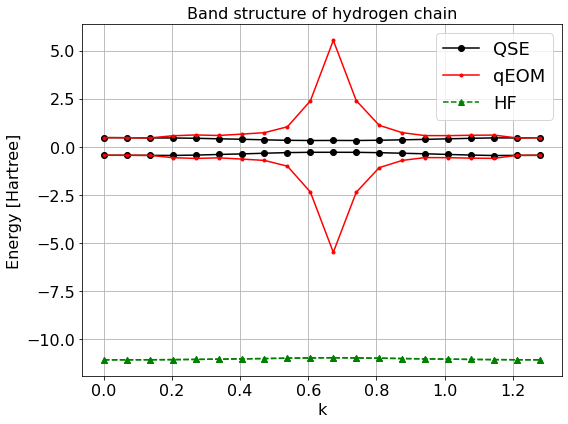

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(kx_list, conduction_qse, color="black", marker="o", label="QSE")
ax.plot(kx_list, conduction_qeom, color="red", marker=".", label="qEOM")
ax.plot(kx_list, conduction_hf, ls="dashed", marker="^", color="green", label="HF")
ax.plot(kx_list, valence_qse, marker="o", color="black")
ax.plot(kx_list, valence_qeom, marker=".", color="red")
ax.plot(kx_list, valence_hf, marker="^", ls="dashed", color="green")

ax.grid(True, which='both', axis='both')
ax.set_xlabel("k")
ax.set_ylabel("Energy [Hartree]")
ax.set_title("Band structure of hydrogen chain")
ax.legend(fontsize=18)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
fig.tight_layout()

In [ ]:
input = qy.QamuyChemistryInput()
ps = input.target_periodic_system
# see also https://sunqm.github.io/pyscf/modules/pbc/gto.html
#BOHR = 0.529 # unit: angstrom
#unitcell_x = 4. * BOHR
#unitcell_yz = 1.
atoms = ["C","C","H", "H"]
coords = [[-0.58442 ,  -0.32662 , 0.0 ],[0.58442 ,  0.32662 ,  0.0  ],[ 0.58442  , 1.40362   ,0.0],[ -0.58442   ,-1.40362 , 0.0    
]]
lattice_vec = [[2.469000000, 0., 0.], [0.,10, 0.], [0., 0., 10]]
kpt_grid_shape = [1, 1, 1] # number of k-points in each direction.
dimension = 1

ps.geometry = qy.periodic_system_geometry(atoms, coords, lattice_vec, kpt_grid_shape)
ps.geometry.dimension = dimension
ps.basis = "sto-3g"
ps.num_excited_states = 0
ps.multiplicity = 1  # required (from ver. 0.18.1)

# CAS
ps.cas = qy.cas(2, 2)
input.solver.type = "VQE"

input.ansatz.type = "UCCD"
input.ansatz.is_state_real = True
input.ansatz.reference_state = "RHF"
input.ansatz.trotter_steps = 4
input.ansatz.initial_parameter = [0.0]
input.ansatz.init_param_random_seed = 1

input.optimizer.type = "BFGS"
input.optimizer.gtol = 1e-6

input.cost_function.type = "SIMPLE"

# exact simulator (state vector)
input.quantum_device.type = "EXACT_SIMULATOR"


job=client.submit(input)

results = client.wait_and_get_job_results([job])
print (results[0].output)
